## 0. 라이브러리 구축

In [105]:
import os # Operanting system
import urllib # URL 작업 라이브러리
import cv2 # Open CV 라이브러리
import numpy as np 
from pixellib.semantic import semantic_segmentation # PixelLib - semantic_segmentation 임포트
from matplotlib import pyplot as plt # 시각화 라이브러리

## 1. 이미지 불러오기 (모듈화)

In [106]:
# 이미지 계속 불러오는 코드 쓰기 귀찮으니 모듈화 해버리자 (결론 - 맛도리)
def imgload(path,show=True):
    # path 저장
    path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'+ path
    # 이미지 불러오기
    img = cv2.imread(path)
    if show:
        # image shape와 image rgb로 확인
        print(img.shape)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    return img, path

## 2. 모델 다운로드(함수화) - PixelLib의 Semantic Segmentation

In [107]:
# 모델도 오래걸리니 함수화 해버리자 (결론 - 무지막지한 맛도리)
def model_load(img_path):
    # PixelLib가 제공하는 모델의 url활용해 semantic segmetation 모델 다운로드
    #PixelLib 라이브러리 에서 가져온 클래스
    model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
    model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 
    model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'
    urllib.request.urlretrieve(model_url, model_file)

    # semantic segmentation을 수행하는 클래스 인스턴스 만들기
    model = semantic_segmentation()
    # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출
    model.load_pascalvoc_model(model_file)
    segvalues, output = model.segmentAsPascalvoc(img_path)
    return segvalues, output

# pascalvoc 데이터의 라벨종류
LABEL_NAMES = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
               'bus','car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 
               'motorbike','person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
              ]

# 컬러맵 만들기 - PixelLib에서 참조한 색상 코드
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

## 사람 배경 blur 실험

(1440, 1370, 3)


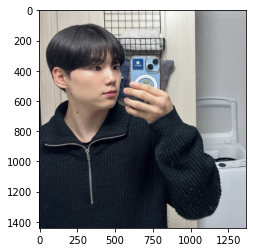

In [108]:
# 이미지 불러오기(함수 사용)
img_orig, img_path = imgload('jonghwan_selfie.png')

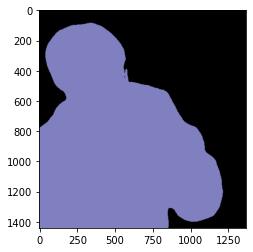

In [109]:
# 모델 불러오기 (함수 사용)
segvalues, output = model_load(img_path)

plt.imshow(output)
plt.show()

In [110]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]])}

In [111]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(class_id,":",LABEL_NAMES[class_id])

0 : background
15 : person


In [112]:
#컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)
colormap[15]

array([192, 128, 128])

In [113]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치
seg_color = (128,128,192)

(1440, 1370)


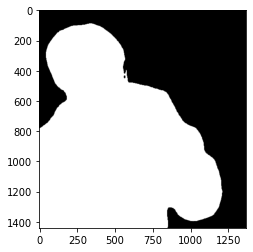

In [114]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)으로 변환
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape)
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력(cmap 사용)
plt.imshow(seg_map, cmap='gray')
plt.show()

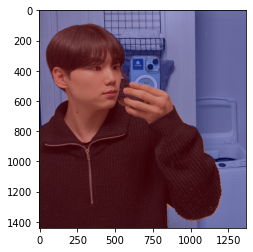

In [115]:
# 원본 이미지를 img_show에 할당 (copy 사용)
# 사람이미지와 배경으로 분리하기 위함.
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크 합성 - 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

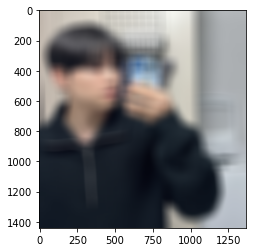

In [116]:
# blurring kernel size 지정하여 blur 처리
img_orig_blur = cv2.blur(img_orig, (80,80))
# blur 처리된 이미지확인
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

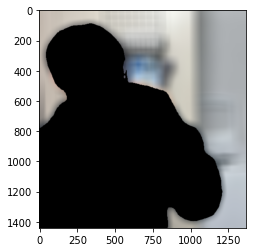

In [117]:
# 마스크 이미지 색상 채널 변경 (Gray to BGR) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# cv2.bitwise_not(): 이미지가 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)
# cv2.bitwise_and()을 사용하면 배경만 있는 이미지 획득
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

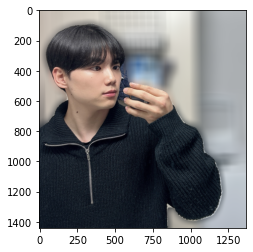

In [118]:
# 이미지 concat - np.where(조건, 참일때, 거짓일때)
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

# 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 고양이 배경 blur 실험 1 (cat 1.png)

(853, 1280, 3)


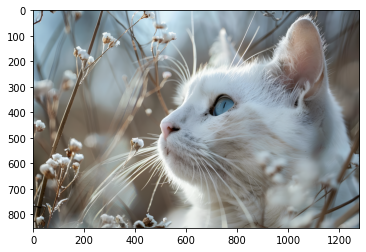

In [119]:
# 이미지 불러오기 함수화
img_orig, img_path = imgload('cat1.png')

In [120]:
# 모델 불러오기 (함수화)
segvalues, output = model_load(img_path)

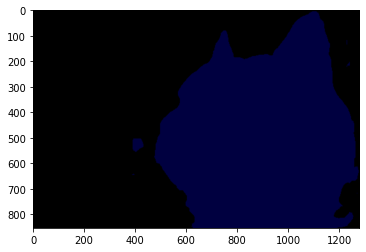

0 : background
8 : cat


In [121]:
# segmentation 수행 여부 확인
plt.imshow(output)
plt.show()

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(class_id,":",LABEL_NAMES[class_id])

In [122]:
#컬러맵 8에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 8번째인 고양이)
colormap[8]

array([64,  0,  0])

In [123]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치
seg_color = (0,0,64)

(853, 1280)


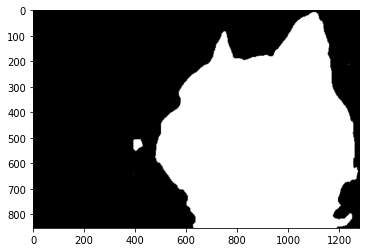

In [124]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)으로 변환
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape)
# seg_color 값이 person을 값이 므로 고양이가 있는 위치를 제외하고는 gray로 출력(cmap 사용)
plt.imshow(seg_map, cmap='gray')
plt.show()

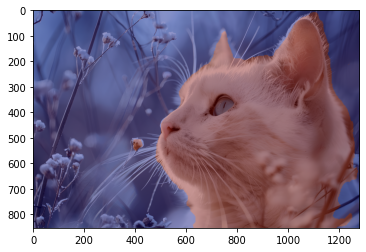

In [125]:
# 원본 이미지를 img_show에 할당 (copy 사용)
# 고양이이미지와 배경으로 분리하기 위함.
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크 합성 - 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

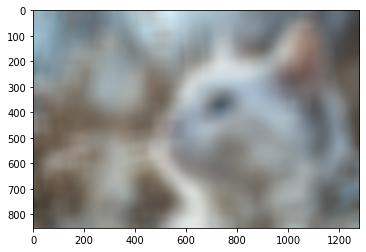

In [126]:
# blurring kernel size 지정하여 blur 처리
img_orig_blur = cv2.blur(img_orig, (80,80))
# blur 처리된 이미지확인
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

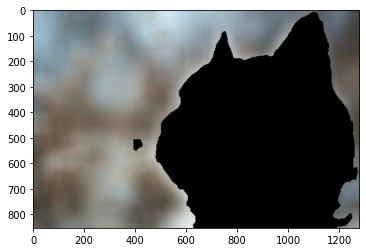

In [127]:
# 마스크 이미지 색상 채널 변경 (Gray to BGR) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# cv2.bitwise_not(): 이미지가 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)
# cv2.bitwise_and()을 사용하면 배경만 있는 이미지 획득
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

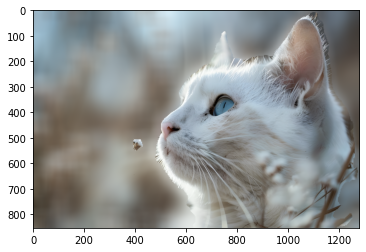

In [128]:
# 이미지 concat - np.where(조건, 참일때, 거짓일때)
img_cat1 = np.where(img_mask_color==255, img_orig, img_bg_blur)

# 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_cat1, cv2.COLOR_BGR2RGB))
plt.show()

## 고양이 배경 blur 실험 2 (cat 2.png)

(5130, 3420, 3)


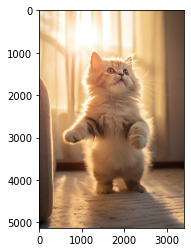

In [129]:
# 이미지 불러오기 함수화
img_orig, img_path = imgload('cat2.png')

In [130]:
segvalues, output = model_load(img_path)

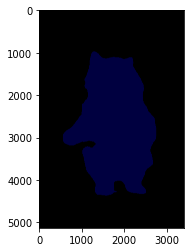

0 : background
8 : cat


In [131]:
# segmentation 수행 여부 확인
plt.imshow(output)
plt.show()

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(class_id,":",LABEL_NAMES[class_id])

In [132]:
#컬러맵 8에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 8번째인 고양이)
colormap[8]

array([64,  0,  0])

In [133]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치
seg_color = (0,0,64)

(5130, 3420)


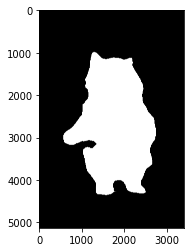

In [134]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)으로 변환
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape)
# seg_color 값이 person을 값이 므로 고양이가 있는 위치를 제외하고는 gray로 출력(cmap 사용)
plt.imshow(seg_map, cmap='gray')
plt.show()

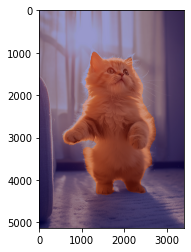

In [135]:
# 원본 이미지를 img_show에 할당 (copy 사용)
# 고양이이미지와 배경으로 분리하기 위함.
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크 합성 - 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

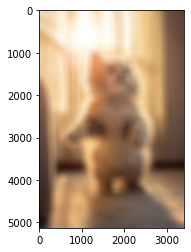

In [136]:
# blurring kernel size 지정하여 blur 처리
img_orig_blur = cv2.blur(img_orig, (200,200))
# blur 처리된 이미지확인
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

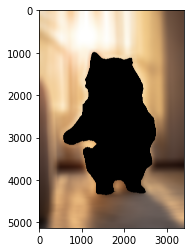

In [137]:
# 마스크 이미지 색상 채널 변경 (Gray to BGR) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# cv2.bitwise_not(): 이미지가 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)
# cv2.bitwise_and()을 사용하면 배경만 있는 이미지 획득
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

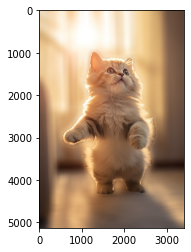

In [138]:
# 이미지 concat - np.where(조건, 참일때, 거짓일때)
img_cat2 = np.where(img_mask_color==255, img_orig, img_bg_blur)

# 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_cat2, cv2.COLOR_BGR2RGB))
plt.show()

## 크로마키 배경전환 사진 만들기

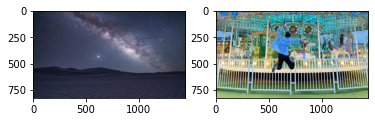

In [139]:
# 이미지 불러오기 함수화
img_bg, img_path1 = imgload('sky_back.png',False)
img_person, img_path2 = imgload('jumpshot.png',False)

# 사람 이미지 크기를 가져옴
height, width, _ = img_person.shape

# 배경 이미지 리사이즈 (사람 이미지 크기에 맞게)
img_bg_resized = cv2.resize(img_bg, (width, height))

# 배경 이미지 출력
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_bg_resized, cv2.COLOR_BGR2RGB))

# 사람 이미지 출력
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_person, cv2.COLOR_BGR2RGB))

plt.show()

In [140]:
segvalues, output = model_load(img_path2)

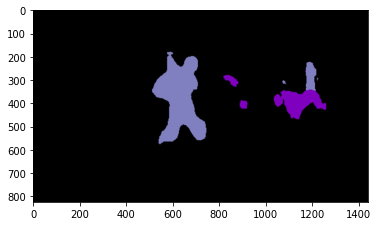

0 : background
13 : horse
15 : person


In [141]:
# segmentation 수행 여부 확인
plt.imshow(output)
plt.show()

#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(class_id,":",LABEL_NAMES[class_id])

In [142]:
#컬러맵 15에 해당하는 배열 출력 
colormap[15]

array([192, 128, 128])

In [143]:
# 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치
seg_color = (128,128,192)

(824, 1440)


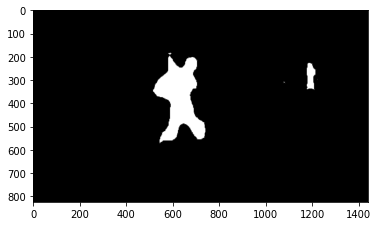

In [144]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)으로 변환
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape)
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력(cmap 사용)
plt.imshow(seg_map, cmap='gray')
plt.show()

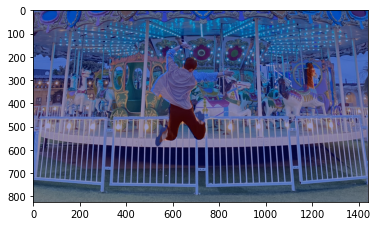

In [145]:
# 원본 이미지를 img_show에 할당 (copy 사용)
# 고양이이미지와 배경으로 분리하기 위함.
img_show = img_person.copy()

# True과 False인 값을 각각 255과 0으로 바꾸기
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크 합성 - 0.6과 0.4는 두 이미지를 섞는 비율
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

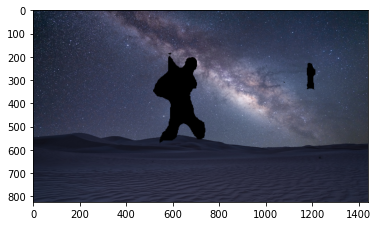

In [146]:
# 마스크 이미지 색상 채널 변경 (Gray to BGR) 
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# cv2.bitwise_not(): 이미지가 반전
img_bg_mask = cv2.bitwise_not(img_mask_color)
# cv2.bitwise_and()을 사용하면 배경만 있는 이미지 획득
img_bg_resized = cv2.bitwise_and(img_bg_resized, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_resized, cv2.COLOR_BGR2RGB))
plt.show()

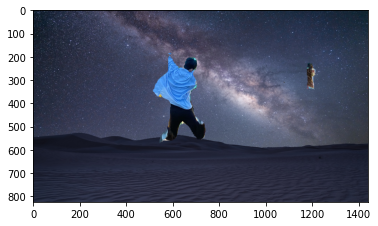

In [147]:
# 이미지 concat - np.where(조건, 참일때, 거짓일때)
img_chroma = np.where(img_mask_color==255, img_person, img_bg_resized)

# 이미지 색상 채널을 변경 (BGR 형식을 RGB 형식으로 변경)
plt.imshow(cv2.cvtColor(img_chroma, cv2.COLOR_BGR2RGB))
plt.show()

In [149]:
# 이미지 저장 
save_path = 'images/image_chroma.png' 
cv2.imwrite(save_path, img_chroma)

True

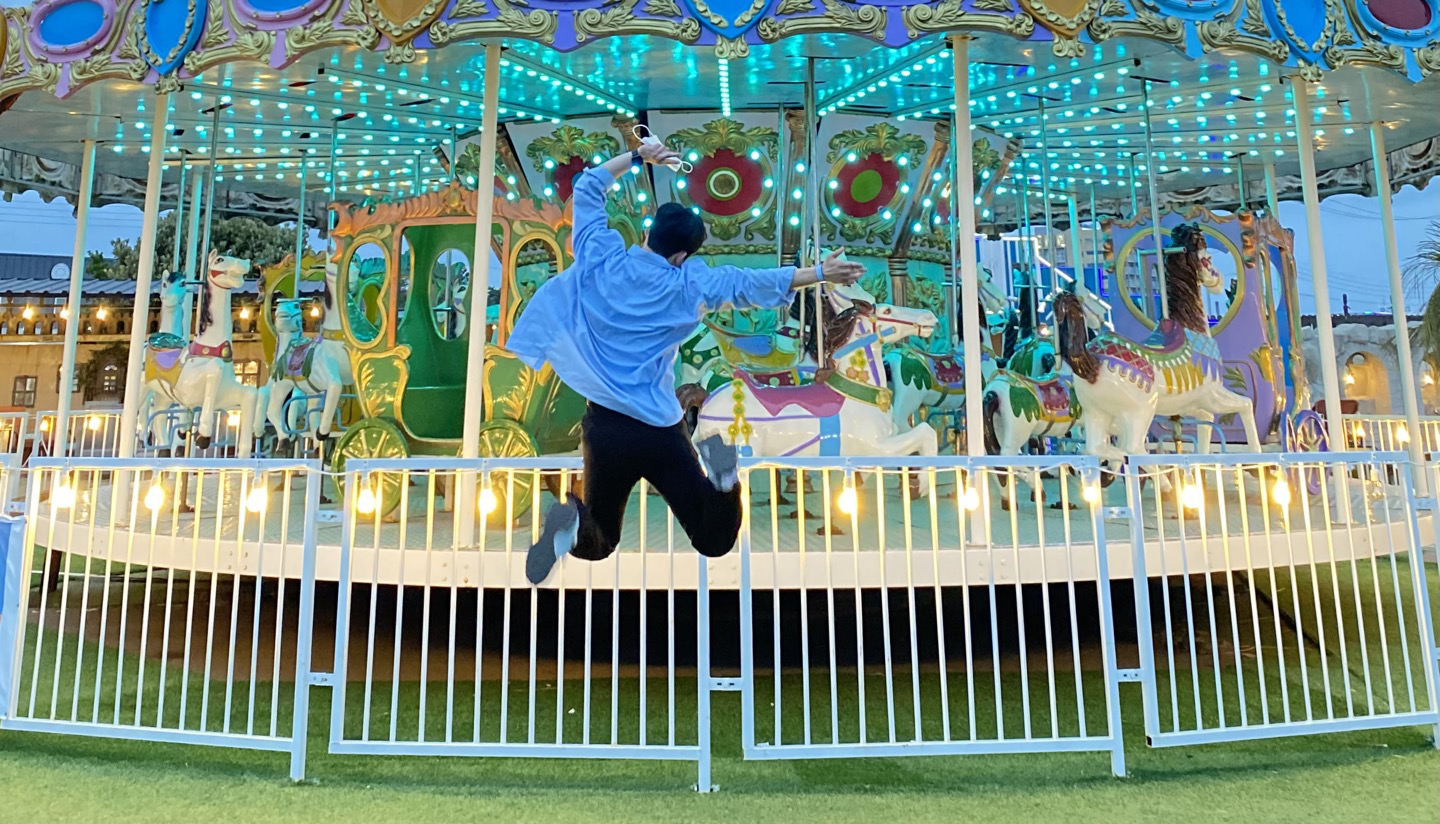

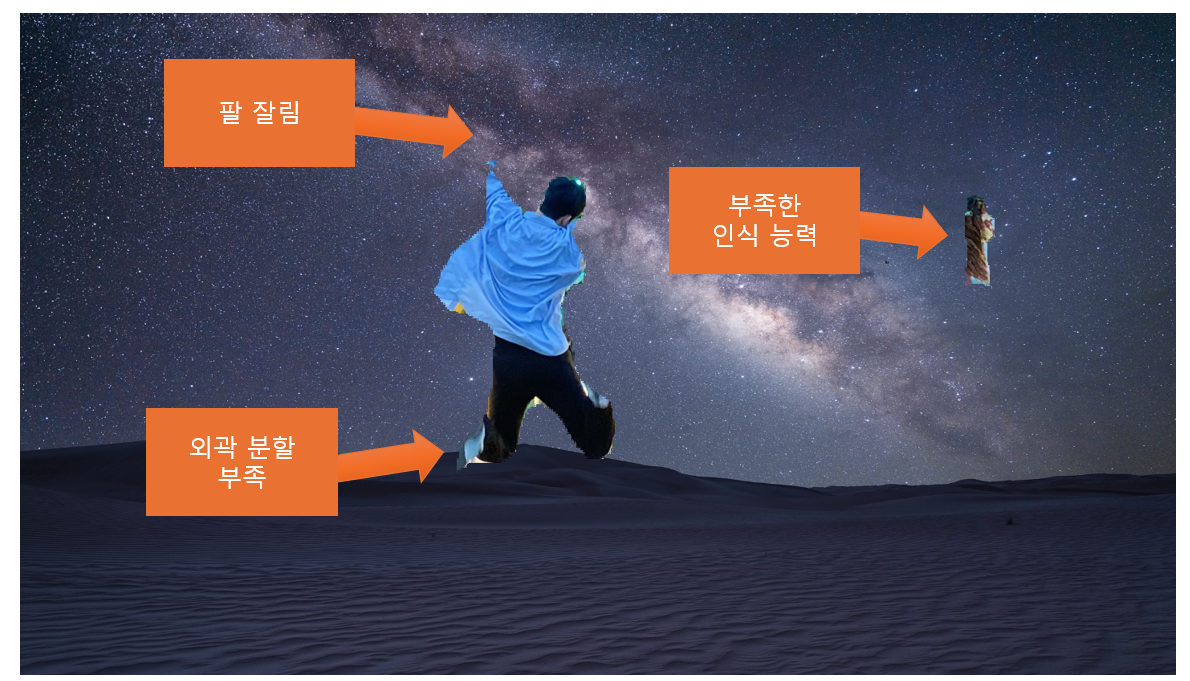

#### 원본 사진과 비교해봤을 때, 팔이 잘린 결과와 외곽 부분에 분할이 정확히 이루어지지 않거나, 말머리를 사람으로 인식하는 등의 결과가 나타났다. 
#### 우선 말머리를 사람으로 인식하는 것은 기존의 학습 및 검증에서 유사한 경우가 있었을 것으로 판단된다.
#### 그렇다면 첫번째 실험에서 진행한 배경과 사람을 분할한 경우와 비교되는 외곽 분할의 부족능력은 어떠한 문제인가? 또한 팔이 잘려 분할이 된 이유는 무엇인지 알아보자

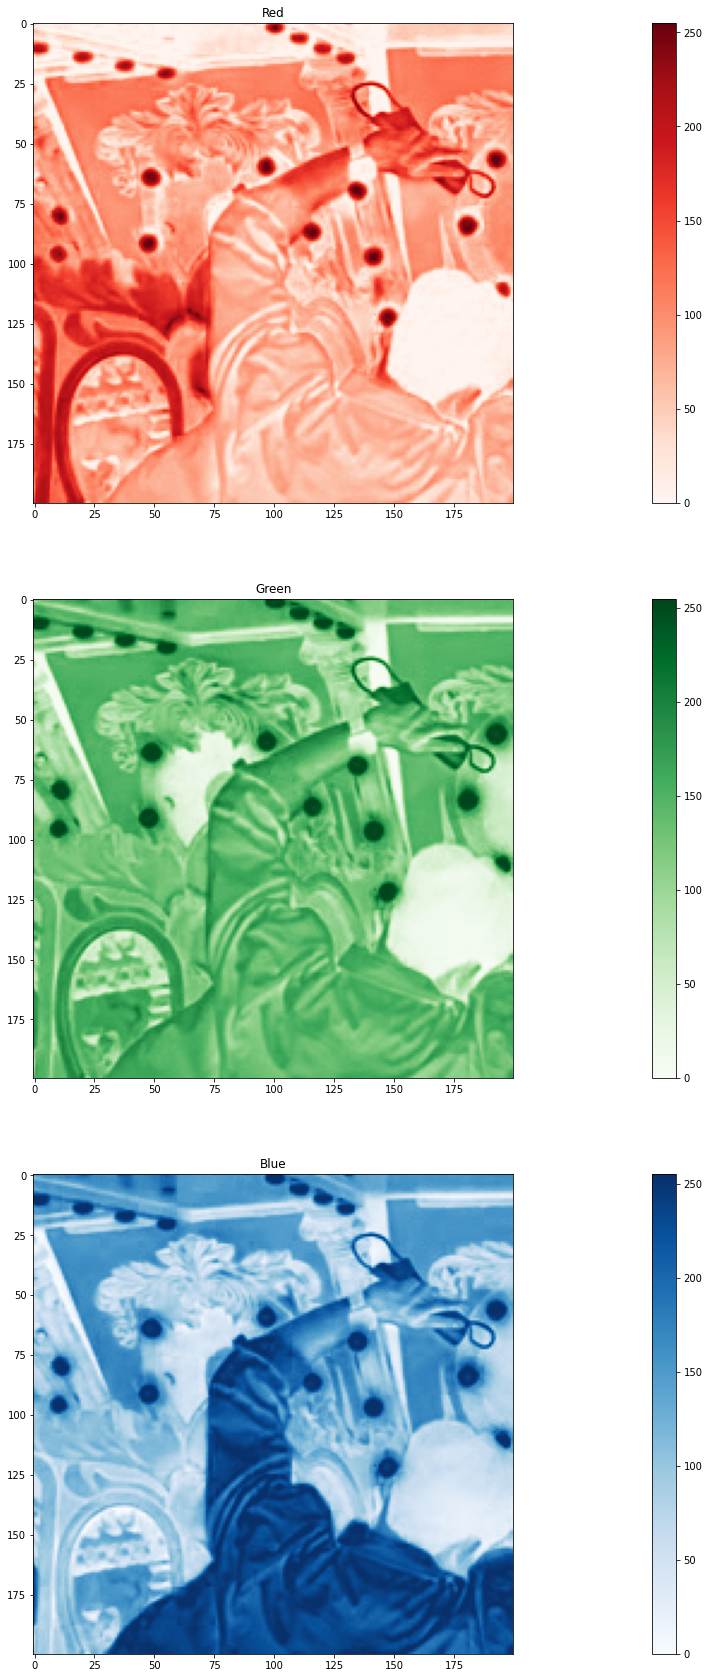

In [156]:
# BGR 채널을 RGB로 변환
img_rgb = cv2.cvtColor(img_person, cv2.COLOR_BGR2RGB)

# 이미지의 잘린 팔 부분을 시각화
x_start, x_end = 500, 700
y_start, y_end = 100, 300
crop_img = img_rgb[y_start:y_end, x_start:x_end]

# R, G, B 채널로 분리
R, G, B = crop_img[:, :, 0], crop_img[:, :, 1], crop_img[:, :, 2]

# R, G, B figure
plt.figure(figsize=(50, 30))

# Red 값 plot
plt.subplot(3, 1, 1)
plt.imshow(R, cmap='Reds')
plt.title('Red')
plt.colorbar() 

# Green 값 plot
plt.subplot(3, 1, 2)
plt.imshow(G, cmap='Greens')
plt.title('Green')
plt.colorbar()

# Blue 값 plot
plt.subplot(3, 1, 3)
plt.imshow(B, cmap='Blues')
plt.title('Blue')
plt.colorbar()

plt.show()

#### 이미지를 확인한 결과 특히 red 채널에서 팔에 갑자기 어두운 값을 가지는 경우가 확인되었다.
#### 즉, 이미지의 edge가 달라지는 부분으로 판단하여 팔이 잘렸을 가능성이 있다.
#### 외곽 부분이 제대로 안잡힌 부분도 확인해보자

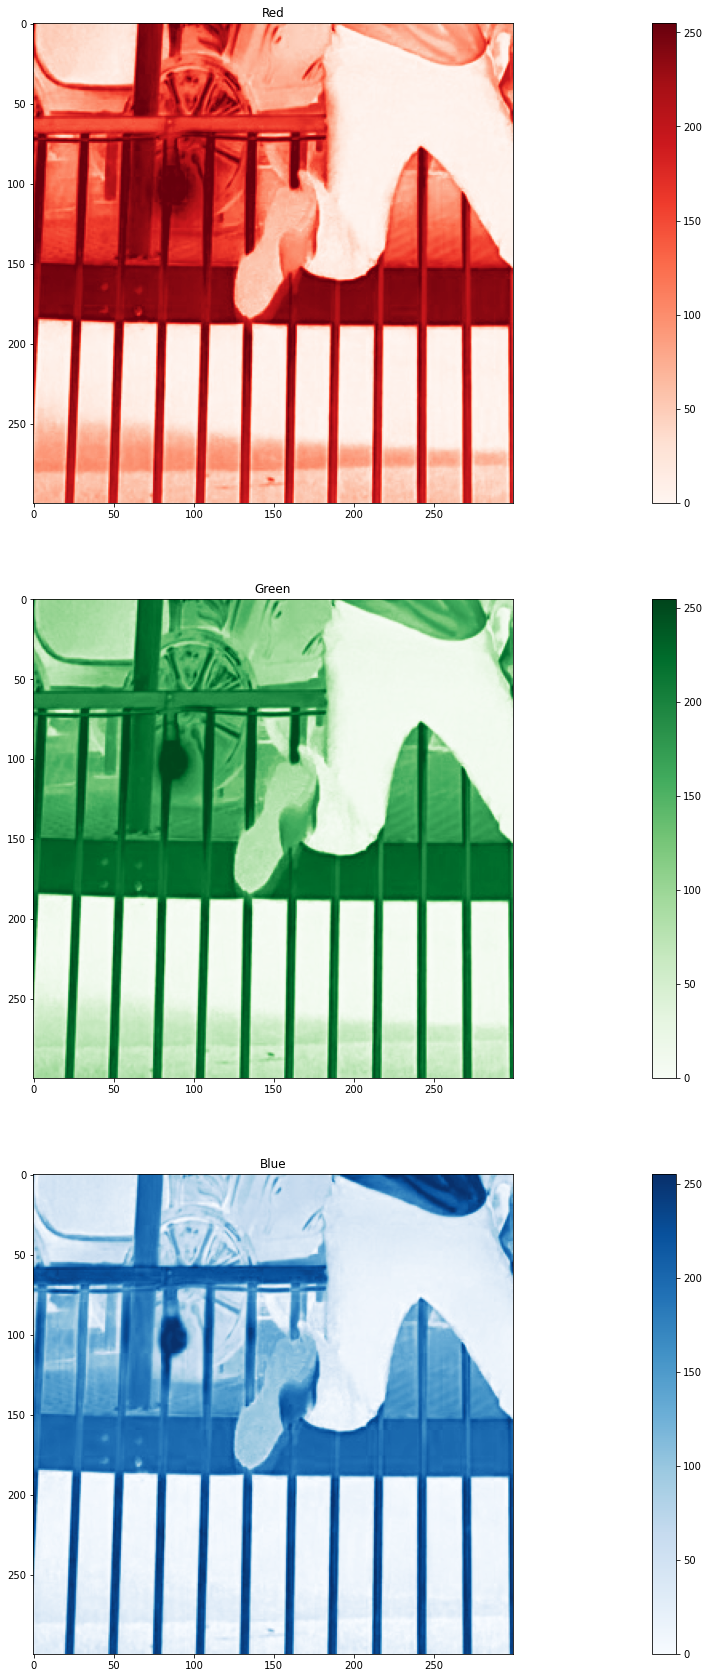

In [158]:
# 이미지의 잘린 팔 부분을 시각화
x_start, x_end = 400, 700
y_start, y_end = 400, 700
crop2_img = img_rgb[y_start:y_end, x_start:x_end]

# R, G, B 채널로 분리
R, G, B = crop2_img[:, :, 0], crop2_img[:, :, 1], crop2_img[:, :, 2]

# R, G, B figure
plt.figure(figsize=(50, 30))

# Red 값 plot
plt.subplot(3, 1, 1)
plt.imshow(R, cmap='Reds')
plt.title('Red')
plt.colorbar() 

# Green 값 plot
plt.subplot(3, 1, 2)
plt.imshow(G, cmap='Greens')
plt.title('Green')
plt.colorbar()

# Blue 값 plot
plt.subplot(3, 1, 3)
plt.imshow(B, cmap='Blues')
plt.title('Blue')
plt.colorbar()

plt.show()

#### 점프 뛰면서 나온 신발 밑창이다... 엣지에서는 전혀 이상이 없으나 잘린 부분이 직선인걸 확인해보면 이미지가 다운샘플링 되었다가 업샘플링 되는 과정에서 철창의 특징이 강하게 남아 철창 라인대로 분할이 된 것임을 확인 할 수 있다.

### 이와 같이 크로마키 과정에서 결과를 확인해본 바 엣지 검출에서의 오류와 convolution 과정에서 발생하는 특징의 손실 혹은 특정 픽셀의 과대평가가 이러한 영향을 미친다는 것을 알수 있다.

### 이러한 결과에서 얻을 수 있는 솔루션은 다음과 같다.
### 1. Refinement - 세분화 처리 : 경계선에서의 세분화 처리 및 경계 정제 알고리즘을 수행하는 방법. 보다 자세히는 인물과 배경의 경계를 정확하게 구분할 수 있는 fully connected CRF 방법을 사용하는 방법이다. 
### 2. 열화상 이미지 등을 통해 3차원의 입체적 정보를 얻을 수 있는 방법을 제시하는 것도 좋은 방법이라 판단된다.
### 3. 가장 간단한 방법은 이미지 자체에 prewitt filter, sobel filter, canny edge 등의 기법을 미리 적용하여 기존 이미지에 덮어씌우는 방법을 통해 더 정확한 edge를 표현해주는 방법이 있을 것이라 판단된다. 프로젝트 제출 이후 진행할 예정이다.

# ----------------------------------------------------------------------------------
### 회고 : segmentation 분야는 영상 처리를 진행해보면서 RGB 값 검출과 intensity 값을 통한 속도장 추출, 나이퀴스트 한계로 인한 앨리어싱 처리 등을 진행한 경험이 있어 나름 자신이 있었다만, 빠른 구조화된 코드를 작성하기엔 아직 경험이 많이 부족하다고 생각되었다. 이후 학습을 진행하면서 더욱 정량적인 결과와 솔루션을 제시하고 싶다는 생각이 들었다.